# Artificial network generation

In [1]:
import numpy as np
import pandas as pd
import sys
import joblib
sys.path.insert(0, "./scripts")
import functions as f
from copy import deepcopy
import networkx as nx
from collections import namedtuple
from itertools import product, combinations
from matplotlib import pyplot as plt
from datetime import datetime
from tqdm import tqdm
from time import sleep
import networkx as nx
%load_ext autoreload
%autoreload 2

In [2]:
cfg = f.get_actual_parametrization("./config.json")

RANDOM_SEED: 19
TEST_NETWORK_SIZE: 500
TEST_NETWORK_LINK_PROB: 0.1
N_CORES_TO_USE: -1
NETWORK_TO_SEARCH_IN: yeast


# Yeast Tnet

In [3]:
cfg = f.update_cfg("./config.json", "NETWORK_TO_SEARCH_IN", "yeast")

RANDOM_SEED: 19
TEST_NETWORK_SIZE: 500
TEST_NETWORK_LINK_PROB: 0.1
N_CORES_TO_USE: -1
NETWORK_TO_SEARCH_IN: yeast


In [4]:
interaction_matrix = f.get_interaction_matrix(cfg)

In [5]:
%%time
motifs_orig, counter_orig = f.motif_search(cfg, interaction_matrix, batch_size=10000)
motifs_orig = motifs_orig["030T"]
counter_orig

CPU times: user 2.54 s, sys: 145 ms, total: 2.68 s
Wall time: 7.73 s


{'021C': 37631, '021D': 1059856, '021U': 26042, '030C': 8, '030T': 3370}

In [6]:
ffl_nodes = list(set(sum([list(map(int, x.split("_"))) for x in motifs_orig], [])))
interaction_matrix_ffl = np.zeros((len(ffl_nodes), len(ffl_nodes)))
for motif in motifs_orig:
    motif = f.split_motif(motif)
    motif_new = list(ffl_nodes.index(x) for x in motif)
    interaction_matrix_ffl[np.ix_(motif_new, motif_new)] = \
    interaction_matrix[np.ix_(motif, motif)]
interaction_matrix_ffl.shape, interaction_matrix_ffl.sum()

((1201, 1201), 4326.0)

# Vertex-based motif network on FFL

In [6]:
motifs = motifs_orig["030T"]

In [7]:
motifs_network = f.build_vmn(motifs, verbose=True)

100%|██████████| 5676765/5676765 [00:17<00:00, 331672.87it/s]


In [8]:
V = nx.Graph(motifs_network)
nx.is_connected(V)

True

In [25]:
def get_network_params(interaction_matrix, verbose=True):
    # motif search
    motifs, counter = f.motif_search(
        cfg, interaction_matrix, batch_size=10000, verbose=False
    )
    motifs = motifs["030T"]
    # TF/TG recognition
    tf_nodes = np.where(interaction_matrix.sum(axis=0) != 0)[0]
    tg_nodes = np.where(interaction_matrix.sum(axis=0) == 0)[0]
    # motif type distribution
    n_tg_nodes_list = np.array(
        [len(set(f.split_motif(motif)) - set(tf_nodes)) for motif in motifs]
    )
    mtype_probs = pd.Series(n_tg_nodes_list).value_counts(normalize=True).sort_index()
    if verbose:
        print("Number of TG in motif distribution:")
        print(mtype_probs)
        print()
    # nodes participation in FFL
    node_part = np.zeros(interaction_matrix.shape[0])
    for triad in motifs:
        for x in map(int, triad.split("_")):
            node_part[x] += 1
    node_part = pd.Series(node_part)
    if verbose:
        print("Node patricipation distribution:")
        print(node_part.value_counts(normalize=False).head())
        print(node_part.value_counts(normalize=True).head())
        print()
    # Distribution of X-unique nodes motifs number
    edges_1 = []
    motifs_0 = []
    types = {i: 0 for i in range(3)}
    for triad in motifs:
        res = 0
        i = 0
        for x in map(int, triad.split("_")):
            res += node_part[x] == 1
            if node_part[x] == 1:
                i = x
        types[res] += 1
        if res == 1:
            edges_1.append(set(f.split_motif(triad))-set([i]))
        if res == 0:
            motifs_0.append(triad)
    types = pd.Series(types)
    unique_nodes = types/sum(types)
    if verbose:
        print("Unique nodes number distribution")
        print(types)
        print(unique_nodes)
        print()
    #  Is edge unique? (for 1-unique node motifs)
    edges_1_part = {"_".join(map(str, sorted(edge))): 0 for edge in edges_1}
    for triad in motifs:
        for x in combinations(f.split_motif(triad), 2):
            edge_1 = "_".join(map(str, sorted(x)))
            try:
                edges_1_part[edge_1] += 1
            except KeyError:
                pass
    edges_1_part = pd.Series(edges_1_part)
    unique_edges_1 = (edges_1_part == 1).value_counts(normalize=True)
    if verbose:
        print("Is edge unique? (for 1-unique node motifs)")
        print((edges_1_part == 1).value_counts())
        print(unique_edges_1)
        print()
    # Distribution of X-unique edges motifs (for 0-unique nodes motifs)
    edges_0_part = {}
    for triad in motifs_0:
        for x in combinations(f.split_motif(triad), 2):
            edge_0 = "_".join(map(str, sorted(x)))
            try:
                edges_0_part[edge_0] += 1
            except KeyError:
                edges_0_part[edge_0] = 1
    edges_0_part = pd.Series(edges_0_part)
    edge_types = {i: 0 for i in range(4)}
    for triad in motifs_0:
        res = 0
        for x in combinations(f.split_motif(triad), 2):
            edge_0 = "_".join(map(str, sorted(x)))
            res += edges_0_part[edge_0] == 1
        edge_types[res] += 1
    edge_types = pd.Series(edge_types)
    unique_edges_0 = edge_types[1:]/sum(edge_types[1:])
    if verbose:
        print("Distribution of X-unique edges motifs (for 0-unique nodes motifs)")
        print(edge_types)
        print(unique_edges_0)
        print()
    Params = namedtuple(
        "Params", "substrate_motifs tf_nodes tg_nodes mtype_probs unique_nodes unique_edges_1 unique_edges_0"
    )
    params = Params(
        *[motifs, tf_nodes, tg_nodes, mtype_probs, unique_nodes, unique_edges_1, unique_edges_0]
    )
    return params

# Generation algorithm

#### Nucleation
One needs a piece of the real network to get reasonable probability estimates for further preferential attachment workflow

In [9]:
def get_network_nucleus(
    interaction_matrix, motifs, motifs_network, min_size, random_seed=cfg["RANDOM_SEED"]
):
    """
    Getting subsample from real network as a nucleus for artificial network
    ________________________________________________________________________
    interaction_matrix (numpy.array) - binary interaction matrix for genes
    motifs (numpy.array) - list of unique identifiers for condidered motifs (FFL triads)
    motifs_network (numpy.array) - vertex-based motifs network (linkage by shared nodes)
    min_size (int) - minimal required size of resulting nucleus (may be slightly higher eventually)
    random_seed (int) - reproducibility parameter
    
    """
    np.random.seed(random_seed)
    substrate_motif_idxs = [np.random.randint(len(motifs))]
    substrate_motifs = np.array([motifs[i] for i in substrate_motif_idxs])
    substrate_size = len(set(sum([f.split_motif(motif) for motif in substrate_motifs], [])))

    # grow network nucleus while required size obtained
    while substrate_size < min_size:
        neighbors = np.where(motifs_network[:, substrate_motif_idxs].sum(axis=1) != 0)[0]
        neighbors = np.array(list(set(neighbors) - set(substrate_motif_idxs)))
        # assignment of weights to candidate motifs by their connectivity
        # with already selected motifs grown substrate network
        weights = motifs_network[neighbors, :][:, substrate_motif_idxs].sum(axis=1)
        weights /= sum(weights)
        substrate_motif_idxs.append(np.random.choice(neighbors, size=1, p=weights)[0])
        substrate_motifs = np.array([motifs[i] for i in substrate_motif_idxs])
        substrate_size = len(set(sum([f.split_motif(motif) for motif in substrate_motifs], [])))

    # interaction matrix building
    G = nx.DiGraph()
    for motif in substrate_motifs:
        nodes = f.split_motif(motif)
        M = nx.DiGraph(interaction_matrix[nodes, :][:, nodes])
        M = nx.relabel_nodes(M, mapping={i: node for i, node in enumerate(nodes)})
        G = nx.compose(G, M)
    substrate_matrix = nx.convert_matrix.to_numpy_array(G)
    return substrate_matrix

#### Parametrization
Motif types and number of shared nodes distributions inference. 

The support set for FFL motif type by TF/TG content is {TTT, TTG} where T and G are for TF and TG respectively.

The support set for the number of shared nodes is {1, 2}. We are not considering 0 as we focus only on the largest connected component of FFL VMN which actually contains all of the FFLs in the yeast Tnet and nearly all (99%) in E.coli Tnet

In [10]:
def get_network_params(substrate_matrix):
    """
    Inference of preferencial attachment algorithm parameters from current substrate network
    ________________________________________________________________________
    substrate_matrix - the netwotk we are growing
    """
    motifs_substr, counter_substr = f.motif_search(
        cfg, substrate_matrix, batch_size=10000, verbose=False
    ) # motif counting
    substrate_motifs = motifs_substr["030T"]
    # TF/TG recognition
    tf_nodes = np.where(substrate_matrix.sum(axis=0) != 0)[0]
    tg_nodes = np.where(substrate_matrix.sum(axis=0) == 0)[0]
    # motif type distribution
    n_tg_nodes_list = np.array(
        [len(set(f.split_motif(motif)) - set(tf_nodes)) for motif in substrate_motifs]
    )
    mtype_probs = pd.Series(n_tg_nodes_list).value_counts(normalize=True).sort_index()
    # shared nodes number distribution
    substrate_vmn = f.build_vmn(substrate_motifs)
    shared_nodes_probs = pd.Series(
        [x for x in substrate_vmn.flatten() if x != 0]
    ).value_counts(normalize=True)
    # results packing
    Params = namedtuple(
        "Params", "substrate_motifs substrate_vmn tf_nodes tg_nodes mtype_probs shared_nodes_probs"
    )
    params = Params(
        *[substrate_motifs, substrate_vmn, tf_nodes, tg_nodes, mtype_probs, shared_nodes_probs]
    )
    return params

#### Single attachment step

Random selection of the inner/outer motif types and number of shared nodes with probabilities from the previous step

In [11]:
def get_attachment_params(params):
    """
    Selection of inner/outer motifs and number of shared nodes
    ________________________________________________________________________
    params - network parameters from previous stage of analysis (see get_network_params)
    """
    # substrate motif type selection
    intype = np.random.choice(params.mtype_probs.index, p=params.mtype_probs.values)
    substrate_type_idxs = np.where(
        np.array([len(set(f.split_motif(x)) - set(params.tf_nodes)) for x in params.substrate_motifs]) == intype
    )[0]
    # buiding VMN for motifs of chosen type
    substrate_type_vmn = params.substrate_vmn[substrate_type_idxs, :][:, substrate_type_idxs]
    type_V = nx.Graph(substrate_type_vmn)
    # weights assignment for chosen motifs by their degree centrality
    weights = np.array([substrate_type_vmn[i, :].sum() for i in range(len(substrate_type_idxs))])
    weights /= sum(weights)
    # weighted random selection of particular substrate network node
    inner_motif_idx = np.random.choice(substrate_type_idxs, p=weights)
    # incoming motif type selection
    outtype = np.random.binomial(1, p=0.5)
    # shared nodes number selection
    shared_nodes = np.random.choice(
        params.shared_nodes_probs.index, p=params.shared_nodes_probs.values
    )
    # results packing
    Params = namedtuple(
        "Params", "substrate_motifs inner_motif_idx intype outtype shared_nodes"
    )
    params = Params(
        *[params.substrate_motifs, inner_motif_idx, intype, outtype, shared_nodes]
    )
    return params

Now is the most tricky part. 

Selection an attachment pattern by the inner/outer motif types and the number of shared nodes fixed on the previous step. The approach strongly depends on the number of shared nodes

Shared node case

<img src="./pics/shared_node_pattern.png" width=600 height=20/>

After a thorough investigation we concluded the following list of patterns:

(inner motif type / outer motif type / isoforms number)

- TTT / TTT - 9 variants
- TTT / TTG - 6 variants
- TTG / TTT - 6 variants
- TTG / TTG - 5 variants

In [12]:
def get_attachment_matrix_shared_node(substrate_matrix, params):
    """
    Attachment patterns constructing for shared node case and random selection the particular one
    ________________________________________________________________________
    substrate_matrix - the netwotk we are growing
    params - attachment parameters from previous stage of analysis (see get_attachment_params)
    """
    inner_motif = f.split_motif(params.substrate_motifs[params.inner_motif_idx])
    inner_motif_matrix = substrate_matrix[inner_motif, :][:, inner_motif]
    outer_motif_matrix = f.build_motif_from_string("0 1 1 0 0 1 0 0 0")
    # check if there are target genes in the considered motifs
    tg_in = inner_motif_matrix.sum(axis=0).argmin() if params.intype == 1 else None
    tg_out = outer_motif_matrix.sum(axis=0).argmin() if params.outtype == 1 else None
    patterns = [] # accumulator of appropriate pattern
    for idx_in, role_out in product(*[range(3)]*2):
        # filtering out inappropriate patterns (by target gene )
        if (idx_in != tg_in) & (role_out == tg_out):
            continue
        if (idx_in == tg_in) & (role_out != tg_out):
            continue
        I = nx.DiGraph(inner_motif_matrix)
        O = nx.DiGraph(outer_motif_matrix)
        mapping = {i: i+3 for i in range(3)}
        mapping[role_out] = idx_in
        O = nx.relabel_nodes(O, mapping=mapping)
        C = nx.compose(I, O)
        compounded_matrix = nx.convert_matrix.to_numpy_array(C)
        patterns.append(compounded_matrix)
    attachment_matrix = patterns[np.random.randint(len(patterns))]
    return attachment_matrix

Shared edge case

<img src="./pics/shared_edge_pattern.png" width=600 height=20/>

Results of isoforms diversity analysis:

(inner motif type / outer motif type / isoforms number)

- TTT / TTT - 9 variants
- TTT / TTG - 3 variants
- TTG / TTT - 3 variants
- TTG / TTG - 5 variants

In [13]:
def get_outer_motif_matrix(role_edge):
    """
    Selection of incoming motif matrix based on shared edge type
    """
    if role_edge == (2, 1):
        return f.build_motif_from_string("0 1 1 0 0 0 0 1 0")
    if role_edge == (2, 0):
        return f.build_motif_from_string("0 1 0 0 0 0 1 1 0")
    if role_edge == (1, 0):
        return f.build_motif_from_string("0 0 0 1 0 0 1 1 0")

In [14]:
def get_attachment_matrix_shared_edge(substrate_matrix, params):
    """
    Attachment patterns constructing for shared edge case and random selection the particular one
    ________________________________________________________________________
    substrate_matrix - the netwotk we are growing
    params - attachment parameters from previous stage of analysis (see get_attachment_params)
    """
    inner_motif = f.split_motif(params.substrate_motifs[params.inner_motif_idx])
    inner_motif_matrix = substrate_matrix[inner_motif, :][:, inner_motif]
    inner_nodes_roles = list(inner_motif_matrix.sum(axis=0).astype(int))
    # check if there is a target gene
    tg_in = inner_nodes_roles.index(0) if params.intype == 1 else None
    # assignment roles and corresponding identifiers to the edges
    role_edges = list(combinations(range(2, -1, -1), 2))
    idx_by_role = lambda x: inner_nodes_roles.index(x)
    idx_edges_in = [(idx_by_role(source), idx_by_role(target)) for source, target in role_edges]
    patterns = []
    for idx_edge_in, role_edge_out in product(idx_edges_in, role_edges):
        outer_motif_matrix = get_outer_motif_matrix(role_edge_out)
        outer_nodes_roles = list(outer_motif_matrix.sum(axis=0).astype(int))
        # reveal positions by known edges roles
        idx_by_role = lambda x: outer_nodes_roles.index(x)
        idx_edge_out = tuple(idx_by_role(v) for v in role_edge_out)
        # check if there is a target gene
        tg_out = outer_motif_matrix.sum(axis=0).argmin() if params.outtype == 1 else None
        # filtering out inappropriate patterns (by target gene )
        if (idx_edge_in[0] != tg_in) & (idx_edge_out[0] == tg_out):
            continue
        if (idx_edge_in[0] == tg_in) & (idx_edge_out[0] != tg_out):
            continue
        if (idx_edge_in[1] != tg_in) & (idx_edge_out[1] == tg_out):
            continue
        if (idx_edge_in[1] == tg_in) & (idx_edge_out[1] != tg_out):
            continue
        I = nx.DiGraph(inner_motif_matrix)
        O = nx.DiGraph(outer_motif_matrix)
        mapping = {i: i+3 for i in range(3)}
        mapping[1], mapping[2] = idx_edge_in
        O = nx.relabel_nodes(O, mapping=mapping)
        C = nx.compose(I, O)
        compounded_matrix = nx.convert_matrix.to_numpy_array(C)
        patterns.append(compounded_matrix)
    attachment_matrix = patterns[np.random.randint(len(patterns))]
    return attachment_matrix

#### Update

In [15]:
def update_substrate_matrix(substrate_matrix, attachment_matrix, inner_motif):
    """
    Substrate network update by selected attachment pattern
    ________________________________________________________________________
    substrate_matrix - the netwotk we are growing
    attachment_matrix - randomly selected attachment pattern compatible with chosen params
    inner_motif - inner triad we attach to
    """
    substrate_matrix_upd = deepcopy(substrate_matrix)
    n_nodes_to_join = int(attachment_matrix.shape[0] - 3)
    substrate_matrix_upd = np.concatenate(
        (substrate_matrix_upd, np.zeros((n_nodes_to_join, substrate_matrix_upd.shape[1]))), axis=0
    )
    substrate_matrix_upd = np.concatenate(
        (substrate_matrix_upd, np.zeros((substrate_matrix_upd.shape[0], n_nodes_to_join))), axis=1
    )
    shape = substrate_matrix_upd.shape[0]
    # interaction matrix update
    substrate_matrix_upd[
        np.ix_(range(shape-n_nodes_to_join, shape), range(shape-n_nodes_to_join, shape))
    ] = attachment_matrix[np.ix_(range(3, 3+n_nodes_to_join) ,range(3, 3+n_nodes_to_join))]
    substrate_matrix_upd[
        np.ix_(range(shape-n_nodes_to_join, shape), inner_motif)
    ] = attachment_matrix[np.ix_(range(3, 3+n_nodes_to_join) ,range(3))]
    substrate_matrix_upd[
        np.ix_(inner_motif, range(shape-n_nodes_to_join, shape))
    ] = attachment_matrix[np.ix_(range(3), range(3, 3+n_nodes_to_join))]
    return substrate_matrix_upd

# Stack all in the pipeline

In [16]:
def generate_artificial_network(
    interaction_matrix, 
    motifs=None, 
    motifs_network=None, 
    nucleus_size=50,
    network_size = 1000,
    random_seed=cfg["RANDOM_SEED"]
):
    """
    Aggragated pipeline of artificial network generation
    ________________________________________________________________________
    interaction_matrix (numpy.array) 
        Binary interaction matrix for genes
    motifs (numpy.array, default=None) 
        List of unique identifiers for condidered motifs (FFL triads). 
        If None motif counting is launched
    motifs_network (numpy.array, default=None) 
        Vertex-based motifs network (linkage by shared nodes)
        If None VMN buiding algorithm is launched
    nucleus_size (int, default=50)
        Minimal required size of initial nucleus. 
        The resulting size may be slightly higher as we may attach two nodes per time.
    network_size (int, default=1000)
        Required resulting network size.
        The resulting size may be slightly higher as we may attach two nodes per time.
    random_seed (int, default=19)
        Reproducibility parameter
    """
    assert (motifs is None) & (motifs_network is None) | (motifs is not None)
    np.random.seed(random_seed)
    init_time = datetime.now()
    
    # check if motifs are provided and search them otherwise 
    if motifs is None:
        print("Motifs are not provided. Motif search is in progress...")
        motifs_orig, counter_orig = f.motif_search(
            cfg, interaction_matrix, batch_size=10000, verbose=False
        )
        motifs = motifs_orig["030T"]
        print()
    
    # check if motifs are provided and search them otherwise 
    if motifs_network is None:
        print("Vertex-based FFL net is not provided. VMN building is in progress...")
        motifs_network = f.build_vmn(motifs, verbose=False)
        print()
    
    # nucleus subsampling
    substrate_matrix = get_network_nucleus(
        interaction_matrix, motifs, motifs_network, min_size=nucleus_size
    )
    print(f"Nucleus matrix shape: {substrate_matrix.shape}")
    sleep(2)
    # preferencial attachment start
    substrate_size = substrate_matrix.shape[0]
    pbar = tqdm(initial=substrate_size, total=network_size)
    while substrate_size < network_size:
        network_params = get_network_params(substrate_matrix)
        params = get_attachment_params(network_params)
        if params.shared_nodes == 1:
            attachment_matrix = get_attachment_matrix_shared_node(substrate_matrix, params)
        else:
            attachment_matrix = get_attachment_matrix_shared_edge(substrate_matrix, params)
        inner_motif = f.split_motif(params.substrate_motifs[params.inner_motif_idx])
        substrate_matrix = update_substrate_matrix(substrate_matrix, attachment_matrix, inner_motif)
        substrate_size = substrate_matrix.shape[0]
        n_nodes_to_join = int(attachment_matrix.shape[0] - 3)
        pbar.update(n_nodes_to_join)
    pbar.close()
    sleep(2)
    print()
    print(f"Network has been successfully generated!\nTotal time spent: {datetime.now() - init_time}")
    return substrate_matrix

# Test launch

In [17]:
artificial_matrix = generate_artificial_network(
    interaction_matrix, motifs=motifs, motifs_network=motifs_network,
    nucleus_size=50, network_size=150
)

Nucleus matrix shape: (51, 51)


151it [00:38,  2.61it/s]                         



Network has been successfully generated!
Total time spent: 0:00:43.145858


In [20]:
artificial_matrix.shape, artificial_matrix.sum()

((151, 151), 252.0)

In [28]:
252/151

1.6688741721854305

In [19]:
%%time
motifs_art, counter_art = f.motif_search(cfg, artificial_matrix, batch_size=10000)
counter_art

CPU times: user 25.9 ms, sys: 52 ms, total: 77.8 ms
Wall time: 754 ms


{'021C': 1339, '021D': 1600, '021U': 307, '030C': 0, '030T': 103}

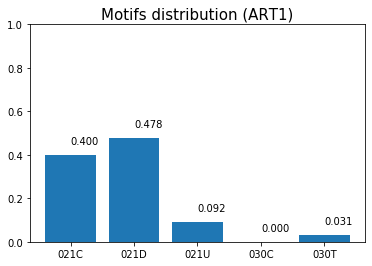

In [29]:
a = pd.Series({'021C': 1339, '021D': 1600, '021U': 307, '030C': 0, '030T': 103})
a = a/sum(a)
plt.title("Motifs distribution (ART1)", fontsize=15)
plt.ylim(0, 1)
plt.bar(a.index, a.values)
for key in a.keys():
    plt.text(x=key, y=a[key]+0.05,
             s=f"{a[key]:.3f}", fontsize=10)
plt.savefig("./pics/motif_distr_art1.png")

In [26]:
art_network_params = get_network_params(artificial_matrix, verbose=True)

Number of TG in motif distribution:
0    0.15534
1    0.84466
dtype: float64

Node patricipation distribution:
1.0    123
2.0     11
3.0      3
5.0      3
6.0      3
dtype: int64
1.0    0.814570
2.0    0.072848
3.0    0.019868
5.0    0.019868
6.0    0.019868
dtype: float64

Unique nodes number distribution
0    27
1    29
2    47
dtype: int64
0    0.262136
1    0.281553
2    0.456311
dtype: float64

Is edge unique? (for 1-unique node motifs)
False    15
True      4
dtype: int64
False    0.789474
True     0.210526
dtype: float64

Distribution of X-unique edges motifs (for 0-unique nodes motifs)
0     7
1    14
2     5
3     1
dtype: int64
1    0.70
2    0.25
3    0.05
dtype: float64



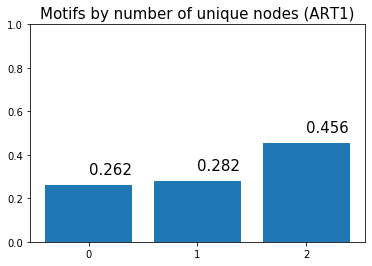

In [27]:
plt.xticks([0, 1, 2])
plt.ylim(0, 1)
plt.title("Motifs by number of unique nodes (ART1)", fontsize=15)
plt.bar(art_network_params.unique_nodes.index, art_network_params.unique_nodes.values)
for i in range(len(art_network_params.unique_nodes)):
    plt.text(x=i, y=art_network_params.unique_nodes[i]+0.05,
             s=f"{art_network_params.unique_nodes[i]:.3f}", fontsize=15)
plt.savefig(f"./pics/motifs_by_uniqnodes_ART1.png")

In [35]:
joblib.dump(artificial_matrix, "artificial_matrix_1.gz")

['artificial_matrix_1.gz']

Motif enrichment

In [32]:
noise_list = np.linspace(0, 80000, 11).astype(int)
score_list = []
for noise in tqdm(noise_list):
    shuffled_matrix = f.get_shuffled_matrix(artificial_matrix, noise)
    score_list.append(1-f.corruption_score(artificial_matrix, shuffled_matrix))

100%|██████████| 11/11 [00:04<00:00,  2.48it/s]


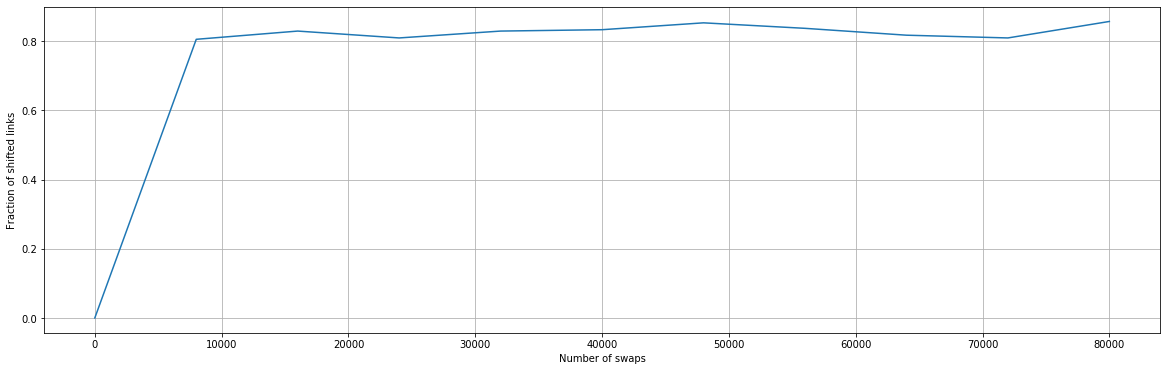

In [33]:
plt.figure(figsize=(20, 6))
plt.grid()
plt.ylabel("Fraction of shifted links")
plt.xlabel("Number of swaps")
plt.plot(noise_list, score_list);

In [7]:
artificial_matrix = joblib.load("artificial_matrix_1.gz")

In [10]:
%%time
motifs, counter_art = f.motif_search(cfg, artificial_matrix, batch_size=10000)
motifs_art = motifs["030T"]
counter_art

CPU times: user 26.2 ms, sys: 51.2 ms, total: 77.4 ms
Wall time: 435 ms


{'021C': 1339, '021D': 1600, '021U': 307, '030C': 0, '030T': 103}

In [7]:
N_SIMS = 1000
N_STEPS = 10
N_SWAPS = 10000
counters = f.generate_random_networks(cfg, artificial_matrix, N_SIMS, N_STEPS, N_SWAPS)

100%|██████████| 100/100 [00:53<00:00,  1.88it/s]


In [8]:
joblib.dump(counters, "./shuffled_counters_1.gz");

In [9]:
counters = joblib.load("./shuffled_counters_1.gz");

100%|██████████| 1000/1000 [00:03<00:00, 261.83it/s]


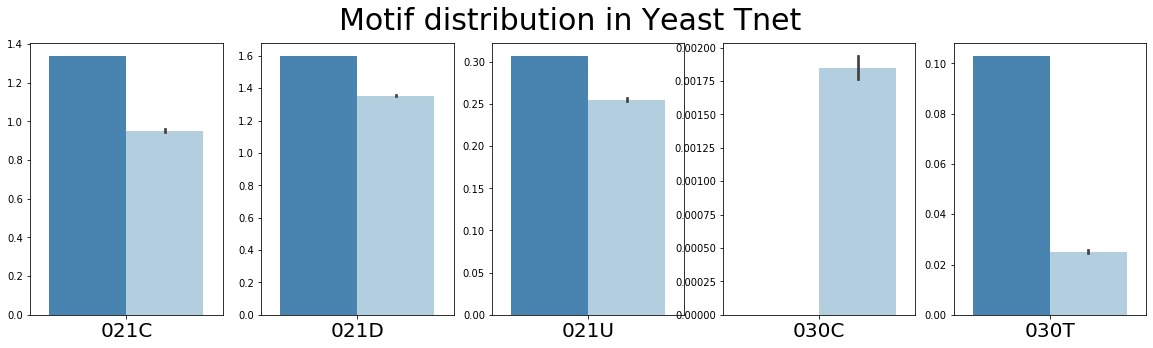

In [11]:
f.plot_distr(counters, counter_art, label="Motif distribution in Yeast Tnet", highlight=False);

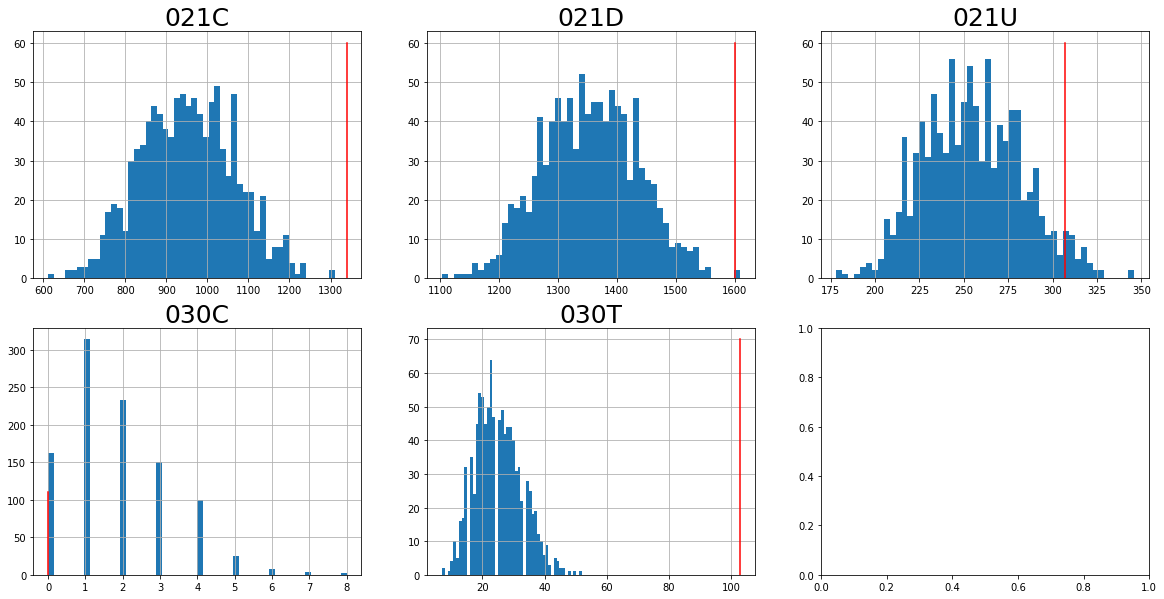

In [12]:
f.plot_distr_2(counters, counter_art, ticks = [60, 60, 60, 110, 70])

In [13]:
f.build_zscores_report(counters, counter_art)

,N_real,mean(N_rand),sd(N_rand),Z-score,P-value,Result
021C,1339,951.778,113.37,3.41557,0,< 0.01
021D,1600,1354.09,81.6672,3.01116,0.002,< 0.05
021U,307,255.068,27.7172,1.87364,0.045,non-significant
030C,0,1.85,1.42109,-1.30182,0.163,non-significant
030T,103,25.127,7.396,10.5291,0,< 0.01


In [8]:
D = nx.DiGraph(artificial_matrix)

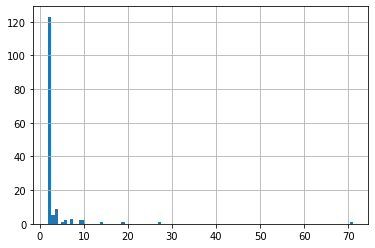

In [10]:
pd.Series(dict(nx.degree(D))).hist(bins=100);

In [11]:
nx.diameter(D.to_undirected()), nx.radius(D.to_undirected())

(6, 3)

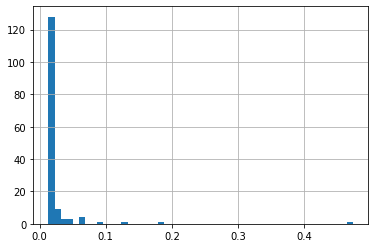

In [12]:
pd.Series(nx.degree_centrality(D)).hist(bins=50);

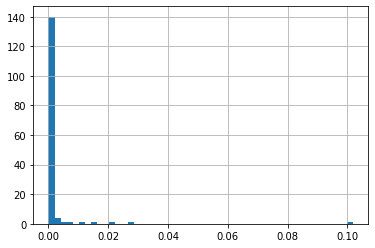

In [13]:
pd.Series(nx.betweenness_centrality(D)).hist(bins=50);

In [14]:
D = nx.DiGraph(interaction_matrix_ffl)

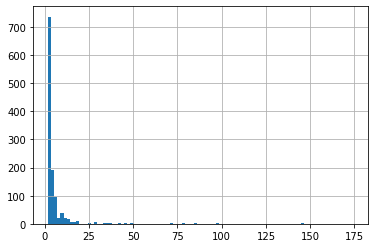

In [15]:
pd.Series(dict(nx.degree(D))).hist(bins=100);

In [16]:
nx.diameter(D.to_undirected()), nx.radius(D.to_undirected())

(6, 4)

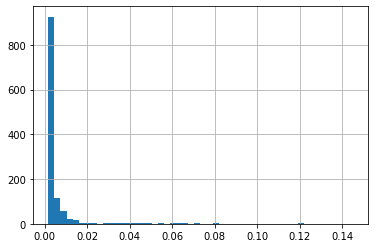

In [17]:
pd.Series(nx.degree_centrality(D)).hist(bins=50)

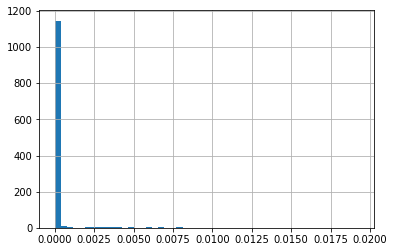

In [18]:
pd.Series(nx.betweenness_centrality(D)).hist(bins=50);